<a href="https://colab.research.google.com/github/icedumpy/KaggleColab/blob/main/Digit%20Recognizer/Digit_Recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mount drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/Kaggle

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/Kaggle


# Import libraries

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Execute

## Load data

In [56]:
df_train = pd.read_csv("Digit Recognizer/train.csv")
df_test  = pd.read_csv("Digit Recognizer/test.csv")

df_submission  = pd.read_csv(c)

## Get data  (image, label)

In [4]:
x = df_train.iloc[:, 1:].values.astype("uint8")
y = df_train["label"].values.astype("uint8")

x_test = df_test.values.astype("uint8")

## Reshape image (1D -> 2D) and Normalize (scale [0, 1])

In [5]:
x = x.reshape(-1, 28, 28, 1)
x_test  = x_test.reshape(-1, 28, 28, 1)

# x = x/255.0
# x_test  = x_test/255.0

## Split data into train, validation

In [6]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=112)

mean = x_train.mean()
std = x_train.std()

x_train = (x_train-mean)/std
x_val = (x_val-mean)/std
x_test = (x_test-mean)/std

## Visualize 

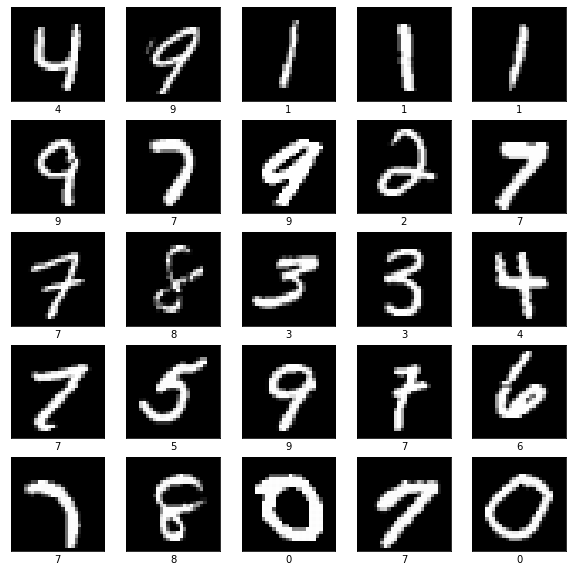

In [7]:
plt.figure(figsize=(10,10))
for i in range(25):
    index = np.random.randint(0, len(x_train)+1)
    plt.subplot(5,5,i+1)
    plt.imshow(x_train[index, :, :, 0], cmap='gray')
    plt.xlabel(y_train[index])
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
plt.show()

## Define model

In [8]:
input = keras.layers.Input((28, 28, 1))
x = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="valid", kernel_initializer='he_uniform')(input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="valid", kernel_initializer='he_uniform')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="valid", kernel_initializer='he_uniform')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Dropout(0.4)(x)

x = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(2, 2), padding="valid", kernel_initializer='he_uniform')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LeakyReLU()(x)

x = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding="valid", kernel_initializer='he_uniform')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding="valid", kernel_initializer='he_uniform')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding="valid", kernel_initializer='he_uniform')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LeakyReLU()(x)
x = keras.layers.Dropout(0.4)(x)

x = keras.layers.GlobalAveragePooling2D()(x)

x = keras.layers.Dense(128)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.LeakyReLU()(x)

x = keras.layers.Dense(10, activation="softmax")(x)

model = keras.Model(inputs=input, outputs=x)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 64)        256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 24, 24, 64)       

## Complie model

In [9]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

## Define callbacks

In [10]:
checkpoint = ModelCheckpoint("Digit Recognizer/model.hdf5", monitor='val_accuracy', verbose= 2, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=20, min_lr=1e-8, verbose=2)
earlystop = EarlyStopping(monitor='val_loss', mode='min', patience=50, verbose=2)
callbacks_list = [checkpoint, reduce_lr, earlystop]

## Calculate class weight

In [11]:
class_weight = y_train.shape[0]/(10*np.bincount(y_train))
class_weight_dict = dict(enumerate(class_weight))
class_weight_dict

{0: 1.018799272286234,
 1: 0.9063933099541408,
 2: 1.0029850746268656,
 3: 0.9821689564454837,
 4: 1.018181818181818,
 5: 1.0926829268292684,
 6: 1.0203461888855148,
 7: 0.9502262443438914,
 8: 1.0316241940435984,
 9: 0.9991079393398751}

## Define datagenerator (for Augmentation)

In [12]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
)

In [13]:
model.fit(
    datagen.flow(x_train, y_train, batch_size=128), 
    steps_per_epoch=len(x_train)//128,
    validation_data = (x_val, y_val),
    epochs=150,
    callbacks = callbacks_list,
    class_weight = class_weight_dict
    )

Epoch 1/150
261/262 [============================>.] - ETA: 0s - loss: 1.5820 - accuracy: 0.9056
Epoch 00001: val_accuracy improved from -inf to 0.92619, saving model to Digit Recognizer/model.hdf5
262/262 [==============================] - 11s 40ms/step - loss: 1.5817 - accuracy: 0.9058 - val_loss: 1.5401 - val_accuracy: 0.9262
Epoch 2/150
261/262 [============================>.] - ETA: 0s - loss: 1.5048 - accuracy: 0.9635
Epoch 00002: val_accuracy improved from 0.92619 to 0.97690, saving model to Digit Recognizer/model.hdf5
262/262 [==============================] - 10s 38ms/step - loss: 1.5048 - accuracy: 0.9636 - val_loss: 1.4866 - val_accuracy: 0.9769
Epoch 3/150
261/262 [============================>.] - ETA: 0s - loss: 1.4950 - accuracy: 0.9716
Epoch 00003: val_accuracy improved from 0.97690 to 0.97917, saving model to Digit Recognizer/model.hdf5
262/262 [==============================] - 10s 38ms/step - loss: 1.4950 - accuracy: 0.9716 - val_loss: 1.4830 - val_accuracy: 0.9792
E

## Load best model

In [32]:
model = keras.models.load_model("Digit Recognizer/model.hdf5")

## Predict test and visualize

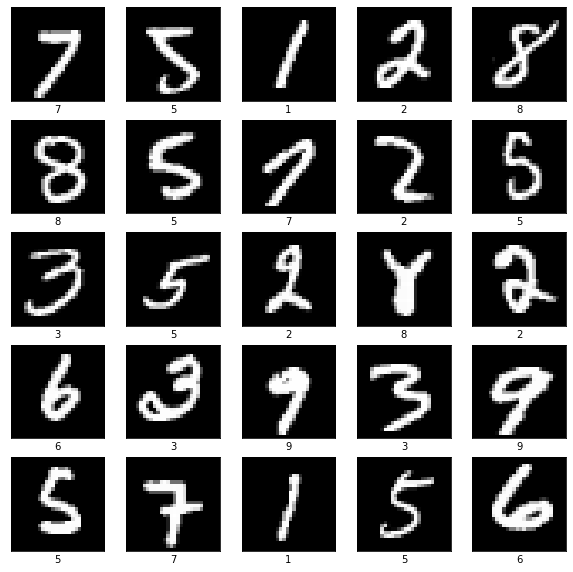

In [47]:
pred_test = np.argmax(model.predict(x_test), axis=1)
plt.figure(figsize=(10,10))
for i in range(25):
    index = np.random.randint(0, len(x_test)+1)
    plt.subplot(5,5,i+1)
    plt.imshow(x_test[index, :, :, 0], cmap='gray')
    plt.xlabel(pred_test[index])
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
plt.show()

## Create submission csv

In [60]:
df_submission["Label"] = pred_test
df_submission.to_csv("Digit Recognizer/submission.csv", index=False)
df_submission

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [61]:
# Rank225/2582 (Top 9%) YaYYYYYYY